In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pytorch_lightning torchmetrics

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

import torchmetrics

import pytorch_lightning as pl

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 KB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 31.8 MB/s eta 0:00:00


In [ ]:
dat = torchvision.datasets.INaturalist(root="./data", version='2021_train_mini', download=True)

  0%|          | 0/44636137542 [00:00<?, ?it/s]

Extracting ./data/2021_train_mini.tgz to ./data


OSError: ignored

# Networks

In [ ]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, padding='same'):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=padding)
        self.act  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=padding)
    
    def forward(self, x):
        return self.act(self.conv2(self.act(self.conv1(x))))

class BasicEncoder(nn.Module):
    def __init__(self, chs=(3,32,64,128,64)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        # self.bn = nn.ModuleList([nn.BatchNorm2d(chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
        self.chs = chs
    
    def forward(self, x):
        for i in range(len(self.chs)-1):
            x = self.pool(self.enc_blocks[i](x))
            # x = self.bn[i](x)
        return x

class BasicDecoder(nn.Module):
    def __init__(self, chs=(64, 64, 32, 16, 8, 4), out_channels=3):
        import math
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 3, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i+1], chs[i+1], padding='valid' if i > 0 else 'same') for i in range(len(chs)-1)]) 
        # self.bn = nn.ModuleList([nn.BatchNorm2d(chs[i+1]) for i in range(len(chs)-1)])

        self.final_conv = nn.Conv2d(chs[-1], out_channels, 4)

        
    def forward(self, x):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            x        = self.dec_blocks[i](x)
            # x = self.bn[i](x)
        
        return self.final_conv(x)

In [ ]:
class DataModule(pl.LightningDataModule):
    def __init__(self, batch_size):
        super().__init__()
        self.save_hyperparameters()
        

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.trainset, batch_size=self.hparams.batch_size,
                                                shuffle=True)
    
    def validation_dataloader(self):
        return torch.utils.data.DataLoader(self.testset, batch_size=self.hparams.batch_size,
                                                shuffle=False)

In [ ]:
import math
MAX_TOKENS = math.ceil(32*32*3/(64*2*2))

class Autoenc(pl.LightningModule):
    def __init__(self, enc, dec, lr=1e-3, batch_size=256):
        super().__init__()
        self.enc = enc
        self.dec = dec
        self.lr = lr
        self.batch_size = batch_size

    
    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        bs, ch, height, width = inputs.shape
        
        rec = torch.zeros_like(inputs)
        
        aux_loss = 0
        for j in range(MAX_TOKENS): 
            z = self.enc(inputs-rec)
            rec = rec + self.dec(z)
            aux_loss += F.mse_loss(rec, inputs)
            
        mse_loss = F.mse_loss(rec, inputs)
        self.log('train_loss', mse_loss, on_step=True, on_epoch=False)
        return mse_loss + aux_loss/MAX_TOKENS
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        bs, ch, height, width = inputs.shape
        
        rec = torch.zeros_like(inputs)
        
        for j in range(MAX_TOKENS): 
            z = self.enc(inputs-rec)
            rec += self.dec(z)
            
        mse_loss = F.mse_loss(rec, inputs)
        self.log('val_loss', mse_loss)
        
    def prepare_data(self):
        # download
        torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
        torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (1.0,1.0,1.0)), transforms.RandomHorizontalFlip()])
            self.trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform, )
            val_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (1.0,1.0,1.0))])
            self.valset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=val_transform)
            
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.trainset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.valset, batch_size=self.batch_size, shuffle=False)

In [ ]:
enc = nn.Sequential(
    nn.Conv2d(3, 8, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
    nn.ReLU(),
    nn.Conv2d(8, 16, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
    nn.ReLU(),
    nn.Conv2d(16, 32, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
    nn.ReLU(),
    nn.Conv2d(32, 64, 4, stride=2, padding=1),           # [batch, 96, 2, 2]
)
dec = nn.Sequential(
    nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
    nn.ReLU(),
    nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
    nn.ReLU(),
    nn.ConvTranspose2d(16, 8, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
    nn.ReLU(),
    nn.ConvTranspose2d(8, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
)


In [ ]:
# enc = BasicEncoder()
# dec = BasicDecoder()
autoenc = Autoenc(enc, dec, lr=1e-3/10, batch_size=1024)

In [ ]:
from pytorch_lightning.callbacks import TQDMProgressBar, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger
torch.set_float32_matmul_precision('medium')
callbacks = [
    TQDMProgressBar(refresh_rate=1),
    ModelCheckpoint(dirpath='./models/', monitor='val_loss', save_top_k=1)
]
conf_name = "res-learn"
logger = CSVLogger("logs", name=conf_name)
trainer = pl.Trainer(callbacks=callbacks, accelerator='gpu', max_epochs=2000, 
                     logger=logger, auto_scale_batch_size=None, auto_lr_find=False,
                     log_every_n_steps=10, resume_from_checkpoint='/content/epoch=982-step=128773.ckpt')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# trainer.tune(autoenc)

In [ ]:
trainer.fit(model=autoenc)

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/epoch=982-step=128773.ckpt
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.8.6 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file epoch=982-step=128773.ckpt`
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:337: UserWarning: The dirpath has changed from '/n/home07/andigu/ml/models' to '/content/models', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
  warnings.warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type       | Params
------------------------------------
0 | enc  | Sequential | 43.5 K
1 | dec

Sanity Checking: 0it [00:00, ?it/s]

Training: 131it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


# Predictor

In [ ]:
MAX_TOKEN = 10

class VLE(pl.LightningModule):
    def __init__(self, enc, dec, n_tok_rec, lr=1e-3, batch_size=256):
        super().__init__()
        self.enc = enc
        self.dec = dec
        for param in enc.parameters():
            param.requires_grad = False
        for param in dec.parameters():
            param.requires_grad = False

        self.lr = lr
        self.batch_size = batch_size
        self.n_tok_rec = n_tok_rec
    
    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        bs, ch, height, width = inputs.shape
        
        rec = torch.zeros_like(inputs)
        tok_rec_logits = self.n_tok_rec(inputs)
        tok_rec_dist = torch.softmax(tok_rec_logits, dim=-1)
        mean_mse = 0
        mean_n_tok = 0
        mean_n_tok2 = 0
        for j in range(MAX_TOKEN): 
            z = self.enc(inputs-rec)
            rec = rec+self.dec(z)
            mean_mse = mean_mse + torch.mean((rec-inputs)**2, dim=(1,2,3)) * tok_rec_dist[:,j]
            mean_n_tok = mean_n_tok + (j+1) * tok_rec_dist[:,j]
            mean_n_tok2 = mean_n_tok2 + (j+1)**2 * tok_rec_dist[:,j]
 
        mean_mse = torch.mean(mean_mse)
        mean_n_tok = torch.mean(mean_n_tok)
        var_n_tok = torch.mean(mean_n_tok2 - mean_n_tok**2)
        
        loss = (mean_mse+0.01*mean_n_tok+0.01*torch.mean(tok_rec_logits**2))*(1-self.current_epoch/20)
        self.log('train_mse_loss', mean_mse, on_step=True, on_epoch=False)
        self.log('train_n_tok', mean_n_tok, on_step=True, on_epoch=False)
        self.log('train_n_tok_var', var_n_tok, on_step=True, on_epoch=False)
        self.log('train_loss', loss, on_step=True, on_epoch=False)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
    def prepare_data(self):
        # download
        torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
        torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            transform = transforms.Compose([
                transforms.ToTensor(), 
                transforms.Normalize((0.5, 0.5, 0.5), (1.0,1.0,1.0)), 
                transforms.RandomHorizontalFlip(),
            ])
            self.trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform, )
            val_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (1.0,1.0,1.0))])
            self.valset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=val_transform)
            
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.trainset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.valset, batch_size=self.batch_size, shuffle=False)

In [ ]:
n_tok_rec = nn.Sequential(
    nn.Conv2d(3, 8, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
    nn.ReLU(),
    nn.Conv2d(8, 16, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
    nn.ReLU(),
    nn.Conv2d(16, 32, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
    nn.ReLU(),
    nn.Conv2d(32, 64, 4, stride=2, padding=1),           # [batch, 96, 2, 2]
    nn.ReLU(),
    nn.Conv2d(64, 128, 4, stride=2, padding=1),
    nn.Flatten(),
    nn.Linear(128, MAX_TOKEN)
)
vle = VLE(enc, dec, n_tok_rec)

In [ ]:
callbacks = [
    TQDMProgressBar(refresh_rate=1),
    ModelCheckpoint(dirpath='./vle-models/', monitor='val_loss', save_top_k=1)
]
conf_name = "vle"
logger = CSVLogger("logs", name=conf_name)
trainer = pl.Trainer(callbacks=callbacks, accelerator='gpu', max_epochs=2000, 
                     logger=logger, auto_scale_batch_size=None, auto_lr_find=False,
                     log_every_n_steps=10)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model=vle)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/configuration_validator.py:106: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params
-----------------------------------------
0 | enc       | Sequential | 43.5 K
1 | dec       | Sequential | 43.5 K
2 | n_tok_rec | Sequential | 176 K 
-----------------------------------------
176 K     Trainable params
87.0 K    Non-trainable params
262 K     Total params
1.052     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


# Eval

In [ ]:
dec = dec.eval().cuda()
enc = enc.eval().cuda()
m = Autoenc(enc,dec,batch_size=500)
m.setup()
dat = m.val_dataloader()

In [ ]:
import skimage.measure    

mses = []
entropies = []
for inputs, _ in dat:
    inputs = inputs.cuda()
    bs, ch, height, width = inputs.shape
    rec = torch.zeros_like(inputs)

    n_tokens = 12
    mses.append([])
    for j in range(n_tokens): 
        z = enc(inputs-rec)
        delta = dec(z)
        rec += delta
        mses[-1].append(torch.mean((rec-inputs)**2, dim=(1,2,3)))
    for img in inputs:
        entropies.append(skimage.measure.shannon_entropy(img.cpu().detach().moveaxis(0,-1).numpy()))

    mses[-1] = torch.stack(mses[-1], dim=1)
mses = torch.cat(mses, dim=0)
entropies = np.array(entropies)

Text(0, 0.5, 'MSE')

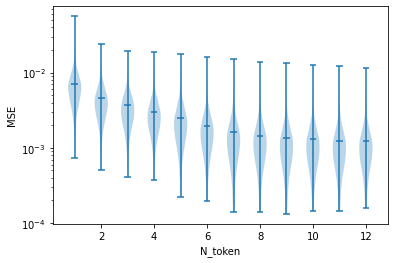

In [ ]:
plt.violinplot(mses.cpu().detach().numpy(), showmedians=True);
plt.yscale('log')
plt.xlabel("N_token")
plt.ylabel("MSE")

Text(0, 0.5, 'Skimage shannon entropy')

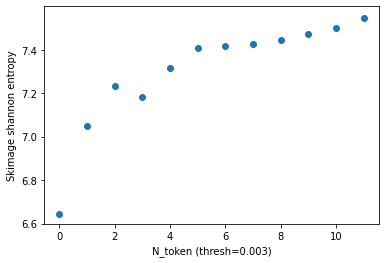

In [ ]:
thresh = 0.003
tmp = lambda x: np.argwhere(x).min() if len(np.argwhere(x)) > 0 else 12
toks = np.array([tmp(x) for x in (mses < thresh).cpu().detach().numpy()])
# plt.scatter(toks, entropies, s=1)
for i in range(12):
    zz = entropies[toks == i]
    if np.sum(toks == i) == 0: continue
    plt.errorbar(i, np.mean(zz), yerr=np.std(zz)/len(zz), c='tab:blue')
    plt.scatter(i, np.mean(zz), c='tab:blue')
plt.xlabel("N_token (thresh=0.003)")
plt.ylabel("Skimage shannon entropy")

In [ ]:
mses.shape

torch.Size([10000, 12])

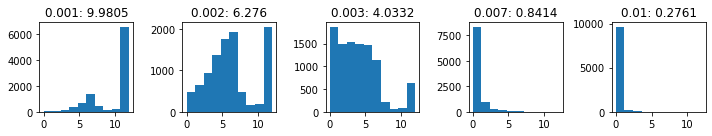

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(10,2))
for i, thresh in enumerate([0.001, 0.002, 0.003, 0.007, 0.01]):
    tmp = lambda x: np.argwhere(x).min() if len(np.argwhere(x)) > 0 else 12
    toks = np.array([tmp(x) for x in (mses < thresh).cpu().detach().numpy()])
    axes[i].hist(toks)
    axes[i].set_title(f'{thresh}: {np.mean(toks)}')
fig.tight_layout()

In [ ]:
batch = next(iter(dat))

1 tensor(0.0084, device='cuda:0', grad_fn=<MeanBackward0>)
2 tensor(0.0053, device='cuda:0', grad_fn=<MeanBackward0>)
3 tensor(0.0042, device='cuda:0', grad_fn=<MeanBackward0>)
4 tensor(0.0033, device='cuda:0', grad_fn=<MeanBackward0>)
5 tensor(0.0027, device='cuda:0', grad_fn=<MeanBackward0>)
6 tensor(0.0022, device='cuda:0', grad_fn=<MeanBackward0>)
7 tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>)
8 tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>)
9 tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>)
10 tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>)
11 tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>)
12 tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>)


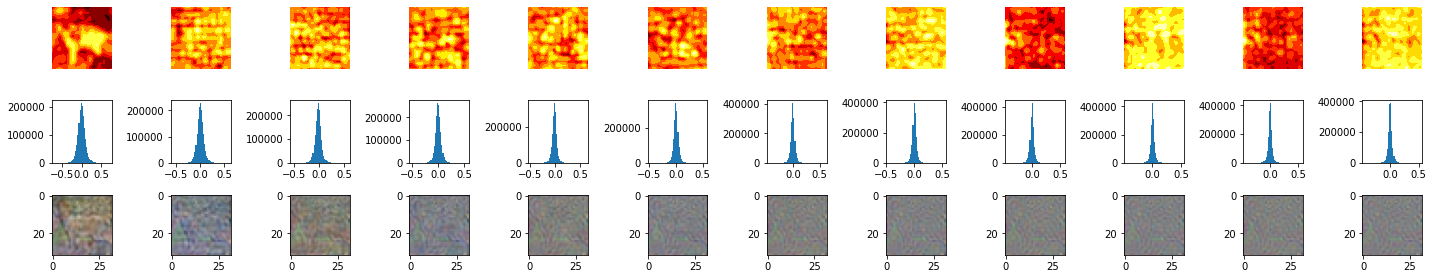

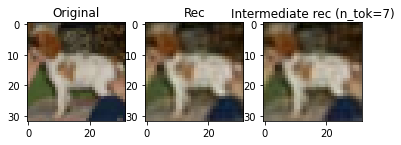

In [ ]:
postprocess = lambda x: x.moveaxis(0,-1).cpu().detach() + 0.5
inputs, labels = batch
inputs= inputs.cuda()
bs, ch, height, width = inputs.shape

rec = torch.zeros_like(inputs)

n_tokens = 12
fig, axes = plt.subplots(3,12, figsize=(20,4))
example_idx = 12
a,b = None, None
for j in range(n_tokens): 
    z = enc(inputs-rec)
    delta = dec(z)
    rec += delta
    hm = np.linalg.norm(postprocess(delta[example_idx]), axis=-1)
    axes[0,j].contourf(hm, cmap='hot', origin='image')
    axes[0,j].axis('off')
    axes[1,j].hist((inputs-rec).cpu().detach().numpy().flatten(), bins=50)
    axes[2,j].imshow(postprocess((inputs-rec)[example_idx]))
    print(j+1, torch.mean((inputs-rec)**2))
    if j == 4: a = rec.clone()
    if j == 7: b = rec.clone()
fig.tight_layout()
plt.figure()
plt.subplot(131)
plt.title("Original")
plt.imshow(postprocess(inputs[example_idx]))
plt.subplot(132)
plt.title("Rec")
plt.imshow(postprocess(rec[example_idx]))
plt.subplot(133)
plt.title("Intermediate rec (n_tok=7)")
plt.imshow(postprocess(b[example_idx]))

In [ ]:
enc = enc.eval()
dec = dec.eval()
m = Autoenc(enc,dec,batch_size=5000)
m.setup()
dm = m.val_dataloader()
batch = next(iter(dm))

In [ ]:
from tqdm.auto import *
inputs, labels = batch
inputs= inputs
bs, ch, height, width = inputs.shape

rec = torch.zeros_like(inputs)

n_tokens = 8
example_idx = 2
a,b = None, None
errs = []
for j in trange(n_tokens): 
    z = enc(inputs-rec)
    delta = dec(z)
    rec += delta
    errs.append(torch.mean((inputs-rec)**2, dim=(1,2,3)))
errs = torch.stack(errs, dim=0)

  0%|          | 0/8 [00:00<?, ?it/s]

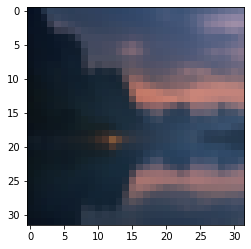

In [ ]:
from skimage.transform import rescale, resize

img = plt.imread("landscape.jpg")
img = img[:484,:484]
img = resize(img, (32,32))
orig_img = img
plt.imshow(img)
img = torch.tensor(img).moveaxis(-1,0).cuda().unsqueeze(0).float()

In [ ]:
rec = torch.zeros_like(img)
tmp = None
for j in range(n_tokens): 
    z = enc(img-rec)
    
    delta = dec(z)
    rec += delta

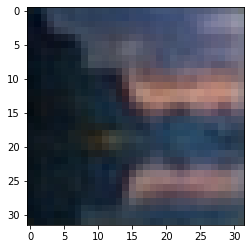

In [ ]:
plt.imshow(rec[0].moveaxis(0,-1).cpu().detach().numpy())

/n/home07/andigu/.local/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/n/home07/andigu/.local/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


RuntimeError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 39.45 GiB total capacity; 37.63 GiB already allocated; 15.81 MiB free; 37.75 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

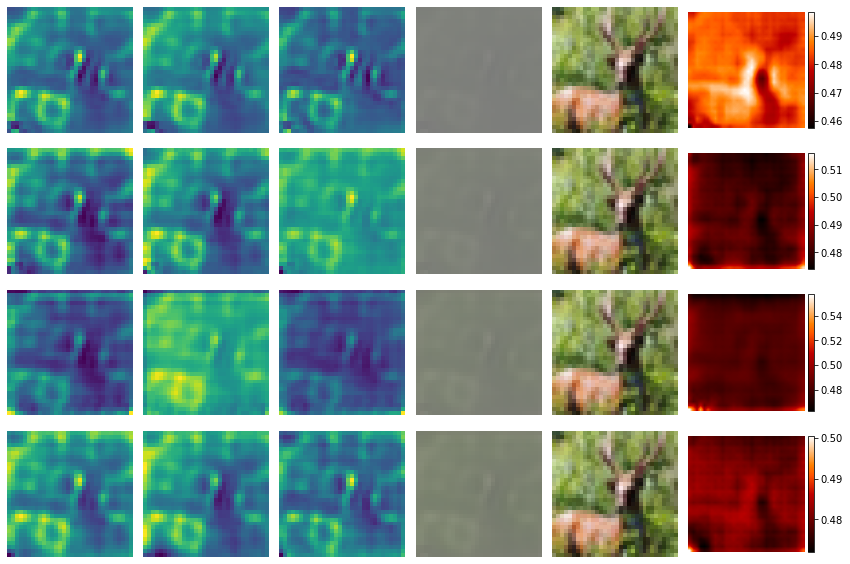

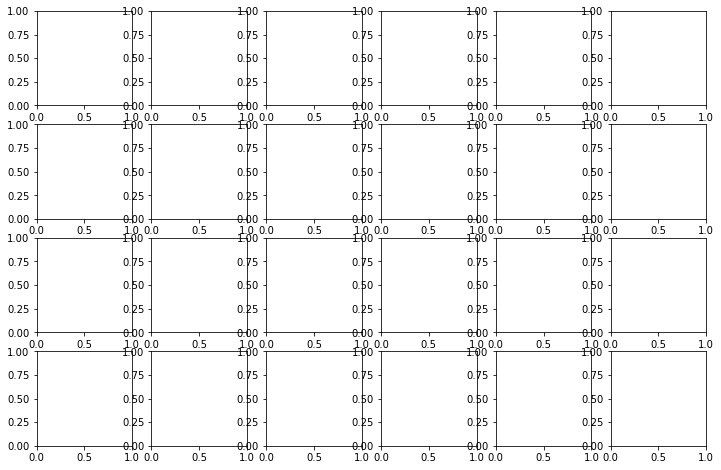

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

bs = inputs.size(0)

z = enc(inputs) # Encode image into some latent space (fixed dim)
# Note: tokens are *continuous*. Not using the codebook idea from VQGAN
hid_state = tok.initialize_inputs(bs) # Start generating tokens with LSTM.         
n_tokens = 4
for example_idx in range(15):
    fig, axes = plt.subplots(n_tokens,6, figsize=(6*2,n_tokens*2))
    total_quant_cost = 0
    rec = torch.zeros_like(inputs)
    # example_idx = 16
    for j in range(n_tokens): 
        out, hid_state = tok(z, hid_state) # Get next token from LSTM 
        # mask = F.elu(self.mask_gen(out))
        # mask /= torch.mean(mask, dim=(1,2,3), keepdims=True)
        mask = F.sigmoid(mask_gen(out))
        z = enc(inputs*mask)
        delta = dec(out)*mask
        rec += delta
        a = delta[example_idx].moveaxis(0,-1).cpu().detach()
        b = (rec[example_idx].moveaxis(0,-1).cpu().detach() + 1)/2
        c = (inputs[example_idx].moveaxis(0,-1).cpu().detach() + 1)/2
        d = np.squeeze(mask[example_idx].moveaxis(0,-1).cpu().detach().numpy())
        for i in range(3):
            axes[j,i].imshow(a[...,i])
        axes[j,3].imshow(b)
        axes[j,4].imshow(c)
        # axes[j,4].contour(d)
        tmp = axes[j,5].imshow(d, cmap='gist_heat', interpolation='bilinear')
        divider = make_axes_locatable(axes[j,5])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(tmp, cax=cax, orientation='vertical')

    for ax in axes.flatten():
        ax.axis('off')
    fig.tight_layout()
    fig.savefig(f"figs/{conf_name}-{example_idx}.pdf", bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


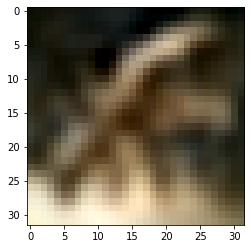

In [ ]:
plt.imshow((rec[example_idx].moveaxis(0,-1).cpu().detach()+1)/2)

In [ ]:
# torch.save({
# 'enc': enc.state_dict(),
# 'tok': tok.state_dict(),
# 'dec': dec.state_dict(),
# }, 'figs/model.pth')
# checkpoint = torch.load('figs/model.pth')
# enc1 = Encoder().to(device)
# tok1 = TokenRNN(256, 512).to(device)
# dec1 = Decoder(256, 3200).to(device)

# enc1.load_state_dict(checkpoint['enc'])
# tok1.load_state_dict(checkpoint['tok'])
# dec1.load_state_dict(checkpoint['dec'])

<All keys matched successfully>